# College Scorecard Data

This data comes from the U.S. Government's College Scorecard Database. While sources such as IPEDs (Integrated Postsecondary Education Data System, from the U.S. Department of Education's National Center for Education Statistics) are explicit about when the data is from, the Scorecard data does not offer a specific timeframe for this data. This dataset was created in 2015 with its metadata last updated in September 2020. Personal knowledge leads me to believe the institution-level data we'll use below is at least a few years old.

Source: <a href="https://catalog.data.gov/dataset/college-scorecard">Data.gov's College Scorecard Data</a>

Project Repositories: GitHub, GitHub.io, Zenodo

In [55]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 2)

#Create dataframe of needed columns from raw data file (second line columns in middle of ranges)
df = pd.read_csv('CS-data-1819.csv', usecols = [3,4,5,14,15,16,21,22,23,26] + list(range(33,42)) + [47,48,55,60,289,290] + list(range(292,301)) + [313,315,316,317] + list(range(320,330)) + [352,353,376] + list(range(378,392)) + list(range(396,405)) + list(range(424,441)) + [1727,1739,1740] + list(range(1977,1981)))
df = df.drop(['SATVR25','SATVR75','SATMT25','SATMT75','INEXPFTE','AVGFACSAL','PFTFAC','TUITIONFEE_PROG','C150_L4','C150_L4_POOLED','C200_L4','RET_FTL4','RET_PTL4','C200_L4_POOLED','POOLYRS200','D200_4_POOLED','D200_L4_POOLED','PCTFLOAN','UG25ABV','CDR2'], axis = 1)

#Data clean up to include only open colleges that award at least a bachelor's degree and to replace missing values
df = df[df['CURROPER'].isin([1])] #1 = yes, currently operating
df = df[df['HIGHDEG'].isin([2, 3, 4])] #2 = associate, 3 = baccalaureate, 4 = doctoral highest degree awarded
df.fillna('', inplace=True) #needed to clean data before joining columns

#Create new NetPrice columns that combine public/private data, then remove duplicate columns and CURROPER (used above)
df['NetPrice'] = df['NPT4_PUB'].astype(str) + df['NPT4_PRIV'].astype(str)
df['NP0-30'] = df['NPT41_PUB'].astype(str) + df['NPT41_PRIV'].astype(str)
df['NP30-48'] = df['NPT42_PUB'].astype(str) + df['NPT42_PRIV'].astype(str)
df['NP48-75'] = df['NPT43_PUB'].astype(str) + df['NPT43_PRIV'].astype(str)
df['NP75-110'] = df['NPT44_PUB'].astype(str) + df['NPT44_PRIV'].astype(str)
df['NP110+'] = df['NPT45_PUB'].astype(str) + df['NPT45_PRIV'].astype(str)
df = df.drop(['CURROPER','NPT4_PUB','NPT4_PRIV','NPT41_PUB','NPT41_PRIV','NPT42_PUB','NPT42_PRIV','NPT43_PUB', 'NPT43_PRIV', 'NPT44_PUB', 'NPT44_PRIV', 'NPT45_PUB', 'NPT45_PRIV'], axis = 1)

#convert categorical columns to integers (replacing null with 0)
df[['HBCU','MENONLY','WOMENONLY','DISTANCEONLY']] = df[['HBCU','MENONLY','WOMENONLY','DISTANCEONLY']].replace('',0)
df[['HBCU','MENONLY','WOMENONLY','DISTANCEONLY']] = df[['HBCU','MENONLY','WOMENONLY','DISTANCEONLY']].astype(int)

#convert remaining numerical-data columns to numeric/float
num_cols = df.columns.drop(['INSTNM','CITY','STABBR','HBCU','MENONLY','WOMENONLY','DISTANCEONLY'])
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

#Create copy of database for type anaylsis
df1 = df.copy()
df1['HBCU'] = df1['HBCU'].replace([0,1],['Not HBCU', 'HBCU'])
df1['MENONLY'] = df1['MENONLY'].replace([0,1],['','Male'])
df1['WOMENONLY'] = df1['WOMENONLY'].replace([0,1],['','Female'])
df1['Gender'] = df1['MENONLY'] + df1['WOMENONLY']
df1['Gender'] = df1['Gender'].replace('','Coed')
df1['CONTROL'] = df1['CONTROL'].replace([1,2,3],['Public','Private (Nonprofit)','For Profit'])
df1['DISTANCEONLY'] = df1['DISTANCEONLY'].replace([0,1], ['In-Person', 'Distance'])
df1['HIGHDEG'] = df1['HIGHDEG'].replace([2,3,4],['Associate\'s','Bachelor\'s','Doctoral'])
df1['All-Types'] = df1['Gender'] + ' ' + df1['DISTANCEONLY'] + ' (' + df1['HBCU'] + ')'

fig = px.sunburst(df1, path=['CONTROL','HBCU','Gender','DISTANCEONLY','HIGHDEG'], title='Higher Education Institutions by Type<br><i>(Click to expand)</i>')
fig.show()

Take time to explore this graphic. Of note, there are no single-gender institutions among the publics, which are largely PWIs (predominately white institutions) and in-person. The largest number of public institutions award an associate's degree or less, while among privates, doctoral institutions are the majority. Among for-profit institutions there are no HBCUs or single-gender institutions.

In [29]:
#Just a few examples of static pie chart codes (for all colleges, Associate's & Above). One is shown below

'''
#This first one is the only variation (public/private/for profit) not included in the chart show below
fig = px.pie(df1, df1['CONTROL'], title='Percentage of Colleges by Operational Type')
fig.show()

fig = px.pie(df1, df1['DISTANCEONLY'], title='Percentage of Colleges by Instruction Type')
fig.show()

fig = px.pie(df1, df1['HBCU'], title='Percentage of Historically Black Colleges/Universities (HBCUs)')
fig.show()

fig = px.pie(df1, df1['Gender'], title='Percentage of Colleges by Gender(s) Served')
fig.show()
'''

fig = px.pie(df1, df1['All-Types'], title='Colleges<br>by Type')
fig.show()

# Who is attending college?
First, let's take a look at enrollment - overall numbers plus gender, racial, and standardized test scores for schools in our dataset. Then, we'll look at costs and admit and graduation rates.

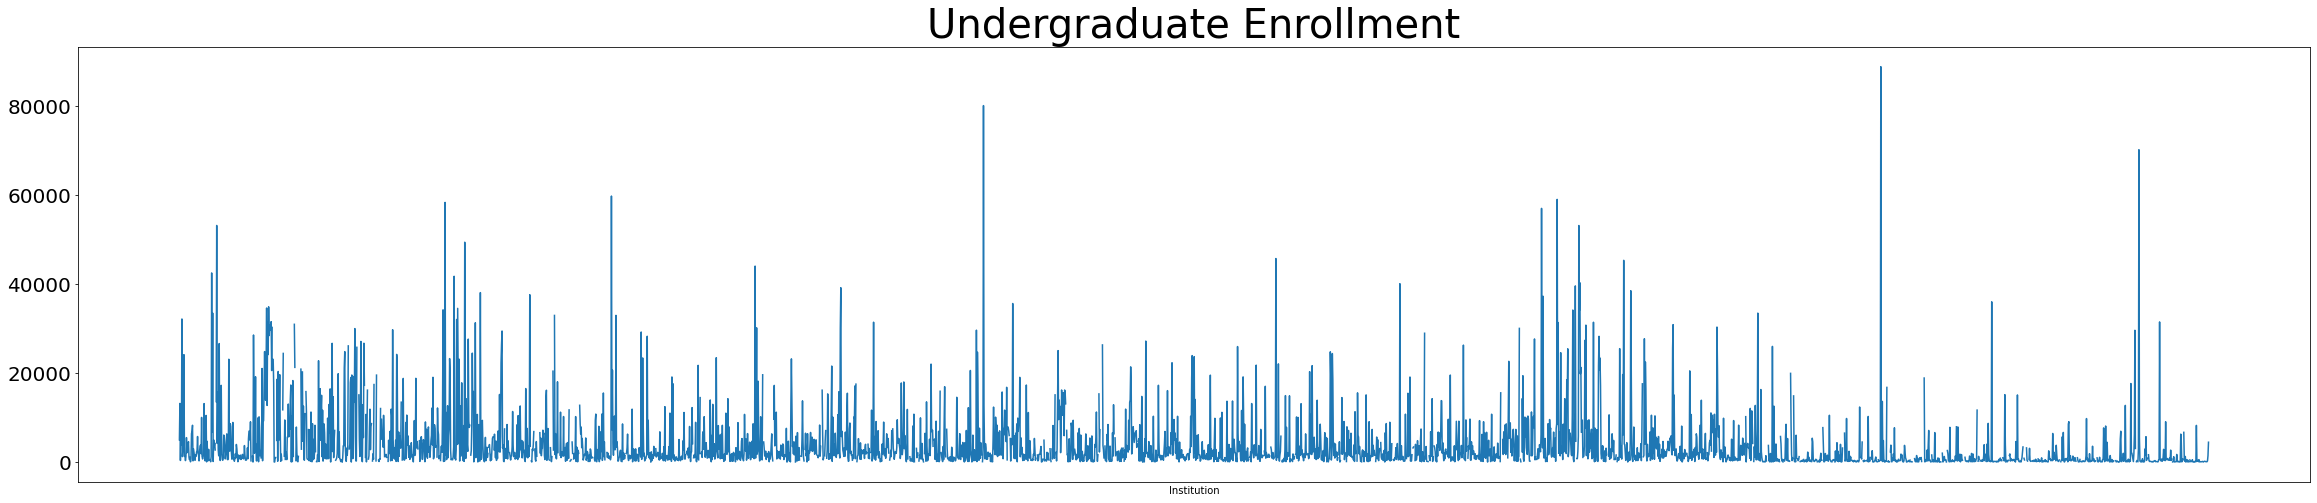

In [4]:
#A quick look at undergraduate enrollment across institutions granting an associate's or higher
df_ug = df[['INSTNM','UGDS']]
df_ug.columns = ['Institution', 'Undergrad Enrollment']
df_ug = df_ug.set_index(['Institution'])
#df_ug #uncomment to see dataframe

df_ug['Undergrad Enrollment'].plot(figsize=(40, 8), fontsize=20)
plt.title('Undergraduate Enrollment', fontsize=40)
plt.xticks([])
plt.show()

This doesn't give much detail, but we do see that most institutions enroll fewer than 20,000 students (perhaps closer to 10,000 or fewer) with only a few spiking near or above 80,000.

In [5]:
#Let's look at the gender and racial breakdowns across all colleges in our dataset

#Dataframes of Enrollment by Gender and Race (for all colleges, Associate's & Above)
df_enroll = df[['INSTNM','UGDS_WHITE','UGDS_BLACK','UGDS_HISP','UGDS_ASIAN','UGDS_AIAN','UGDS_NHPI','UGDS_2MOR','UGDS_NRA','UGDS_UNKN','UGDS_MEN','UGDS_WOMEN']]
df_enroll.columns = ['Institution', 'White %', 'Black %', 'Hispanic %', 'Asian %', 'American Indian %', 'Hawaiian/Pacific Islander %', '2 or More Races %', 'Non-Resident %', 'Unknown Race %', 'Men %', 'Women %']
df_enroll = df_enroll.set_index(['Institution'])
df_enroll = df_enroll.multiply(100)
uggender = df_enroll[['Men %', 'Women %']]
ugrace =  df_enroll[['White %', 'Black %', 'Hispanic %', 'Asian %', 'American Indian %', 'Hawaiian/Pacific Islander %', '2 or More Races %', 'Non-Resident %', 'Unknown Race %']]

#Gender Breakdown (for all colleges, Associate's & Above)
fig = go.Figure(data=[go.Pie(labels=['Women','Men'], values=[uggender['Women %'].mean(),uggender['Men %'].mean()])])
fig.update_layout(barmode='stack',title='Gender Breakdown of Undergraduates Across All Colleges')
fig.update(layout_showlegend=False)
fig.update_traces(hoverinfo='label+percent', textinfo='label + percent', textfont_size=20,
                  marker=dict(colors=['red', 'blue']))
fig.show()

In [6]:
#Racial Breakdown (for all colleges, Associate's & Above)
fig = go.Figure(data=[go.Pie(labels=['White','Black','Hispanic','Asian','American Indian','Hawaiian/Pacific Islander','2 or More Races','Non-Resident','Unknown'], 
                             values=[ugrace['White %'].mean(),ugrace['Black %'].mean(),ugrace['Hispanic %'].mean(),ugrace['Asian %'].mean(),ugrace['American Indian %'].mean(),ugrace['Hawaiian/Pacific Islander %'].mean(),ugrace['2 or More Races %'].mean(),ugrace['Non-Resident %'].mean(),ugrace['Unknown Race %'].mean()])])
fig.update_layout(barmode='stack',title='Racial Breakdown of Undergraduates Across All Colleges')
fig.update_traces(hoverinfo='label+percent', textfont_size=15)
fig.show()

# Next up, who gets into college? A look at rates of admission

In [10]:
#Calculate avg admit rates for various types of colleges
means2 = df1.groupby('CONTROL')['ADM_RATE_ALL'].mean()*100
mean_HBCU = df1.groupby('HBCU')['ADM_RATE_ALL'].mean()*100
mean_gender = df1.groupby('Gender')['ADM_RATE_ALL'].mean()*100
mean_dist = df1.groupby('DISTANCEONLY')['ADM_RATE_ALL'].mean()*100
mean_bydeg = df1.groupby('HIGHDEG')['ADM_RATE_ALL'].mean()*100
admit_rates_by_type = (means2, mean_HBCU, mean_gender, mean_dist, mean_bydeg) #group the above

#Build a dataframe and include the overall average admit rate
avgadm = df1['ADM_RATE_ALL'].mean()*100
admit_types = pd.DataFrame(list(admit_rates_by_type)).T.bfill(axis=1)[['ADM_RATE_ALL']]
new_row = pd.DataFrame(data={'ADM_RATE_ALL':avgadm}, index=['Average for All Colleges'])
admit_types.columns = ['Avg Admit Rate', 'c1', 'c2', 'c3','c4']
admit_types = pd.concat([admit_types, new_row]).bfill(axis=1)
admit_types = admit_types.drop(columns=['c1','c2','c3','c4','ADM_RATE_ALL']).sort_values(by='Avg Admit Rate')

#Now let's graph them
fig = px.bar(admit_types, x='Avg Admit Rate', y=admit_types.index, orientation='h', labels={'index':'Type'}, title='Admit Rates by Type of Institution')
fig.add_shape(type='line', line_color='salmon', line_width=3, opacity=1, line_dash='dot', y0=0, y1=1, yref='paper', x0=avgadm, x1=avgadm)
fig.show()

In [30]:
#Now by their intersectional definitions (again, for the full dataset)

means1 = df1.groupby('All-Types')['ADM_RATE_ALL'].mean()*100
means1.sort_values()
avg_admit_multi = pd.DataFrame(list(means1), columns=['Avg Admit Rate'], index=[means1.index]).sort_values(by='Avg Admit Rate').dropna()

fig = px.bar(avg_admit_multi, x="Avg Admit Rate", y=means1.index, orientation='h', labels={'y':'Type'}, title='Admit Rates for Multi-Types of Institutions')
fig.add_shape(type='line', line_color='salmon', line_width=3, opacity=1, line_dash='dot', y0=0, y1=1, yref='paper', x0=avgadm, x1=avgadm)
fig.show()

In [7]:
#What is the range of standardized test scores submitted by applicants to 4-year institutions?

#Create dataframes for 2- and 4-year schools, then adjusted test scores
twoyr = df1[df1['HIGHDEG'].isin(['Associate\'s'])] #institutions with associate's degrees as the highest offering
fouryr = df1[df1['HIGHDEG'].isin(['Bachelor\'s','Doctoral'])] #institutions with bachelor's and doctoral degrees as the highest offering
adjscores = fouryr.copy()
adjscores.set_index(['INSTNM'])
adjscores['ACTCMMID'] = adjscores['ACTCMMID'] / 36 *100 #"Standardize" ACT scores as a percentage of their "perfect" 36 score for comparison
adjscores['SAT_AVG_ALL'] = adjscores['SAT_AVG_ALL'] / 1600 *100 #"Standardize" SAT scores as a percentage of their "perfect" 1600 score for comparison
adjscores = adjscores.drop(['LATITUDE','LONGITUDE','CCBASIC','MENONLY','WOMENONLY','RELAFFIL','ACTCM25','ACTCM75','PPTUG_EF','NUM4_PUB','NUM4_PRIV','TUITIONFEE_IN','TUITIONFEE_OUT','TUITFTE','POOLYRS','PFTFTUG1_EF'], axis = 1)

x_data = ['ACT Midpoint','SAT Average']
y0 = adjscores['ACTCMMID']
y1 = adjscores['SAT_AVG_ALL']
y_data = [y0,y1]

fig = go.Figure()

for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Box(y=yd, name=xd, boxpoints='all',marker_size=2, line_width=1))

fig.update_layout(title='Range of Standardized Test Scores (out of 100%)',
    yaxis=dict(range=(0,100), showgrid=True, zeroline=True, gridwidth=1, zerolinewidth=2,),
    margin=dict(l=30,r=30,b=50,t=50,),paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',showlegend=False)
fig.show()

# Now to look at college costs
We'll look at overall tuition and fees of 4-year institutions, then their net price (overall and by family income levels)

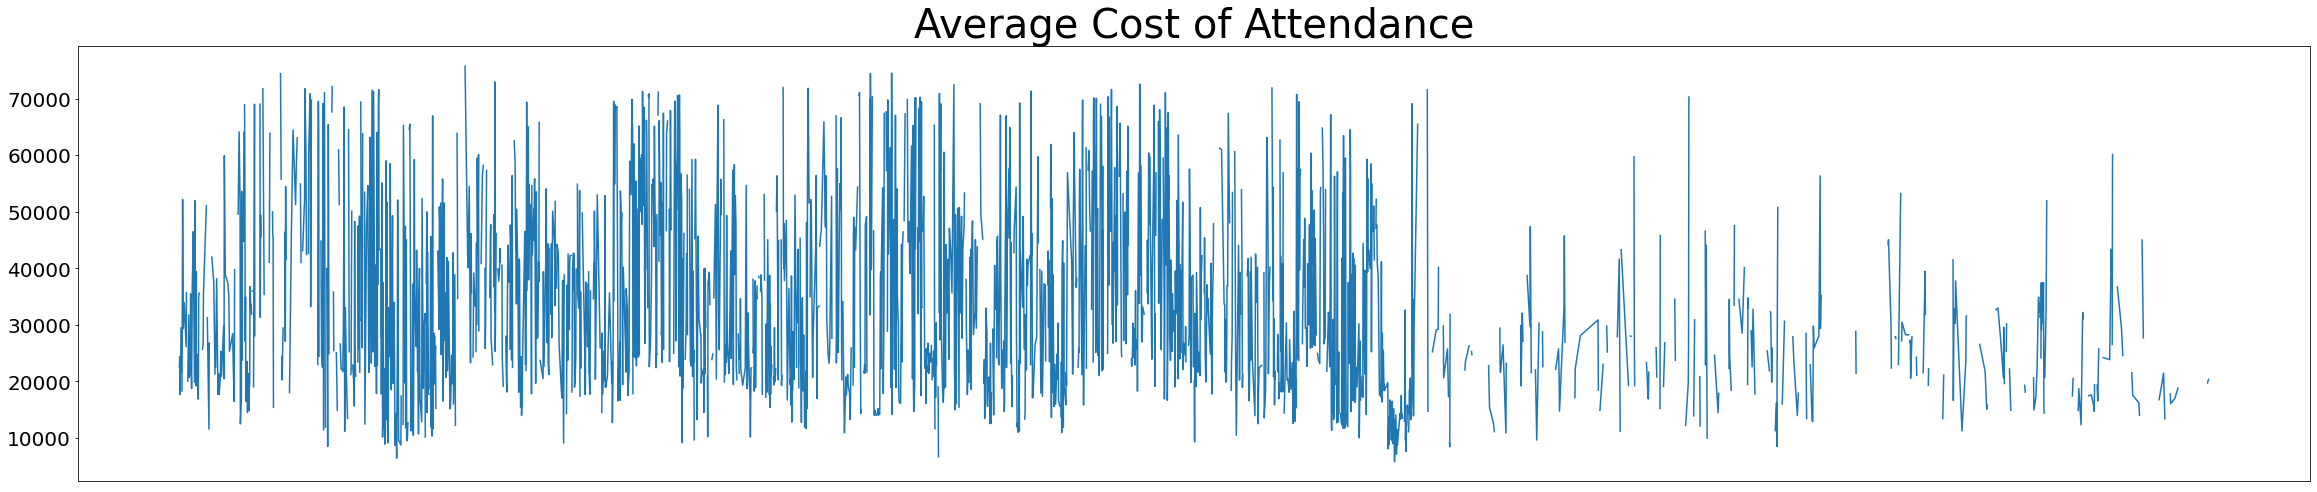

In [8]:
#Graph cost of attedance across all 4-year institutions in dataset
fouryr['COSTT4_A'].plot(figsize=(40, 8), fontsize=20)
plt.title('Average Cost of Attendance', fontsize=40)
plt.xticks([])
plt.show()

In [9]:
#Let's examine the average net price and net price by income brackets for 4-year colleges
x_data = ['Avg Net Price','$0-30k Income','$30-48k Income','$48-75 Income','$75-110k Income','$110+k Income']
y0 = fouryr['NetPrice']
y1 = fouryr['NP0-30']
y2 = fouryr['NP30-48']
y3 = fouryr['NP48-75']
y4 = fouryr['NP75-110']
y5 = fouryr['NP110+']
y_data = [y0,y1,y2,y3,y4,y5]

fig = go.Figure()

for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Box(y=yd, name=xd, boxpoints='all',marker_size=2, line_width=1))

fig.update_layout(title='Annual Net Price by Family Income for 4-Year Colleges',
    yaxis=dict(range=(-11000,71000), showgrid=True, zeroline=True, gridwidth=1, zerolinewidth=2,),
    margin=dict(l=30,r=30,b=50,t=50,),paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',showlegend=False)
fig.show()

A negative net price indicates that the average grant or scholarship aid exceeded the cost of attendance, per the <a href="https://collegescorecard.ed.gov/data/glossary/">U.S. Department of Education</a>.

# To understand success, we turn to graduation rates

Admit rates are great to know, but how do students succeed when in college? Let's turn to graduation rates. From here on, we'll just look at 4-year institutions (highest degree of bachelor's or doctoral). The typical measure is a 6-year completion rate (or 150% of the expected time to finish a 4-year degree). First, we'll take a quick look at the average 6- and 8-year rates before diving deeper into the 6-year data.

In [12]:
#Calculate average graduate rates
avggrad_sixyr = fouryr['C150_4'].mean()*100
avggrad_eightyr = fouryr['C200_4'].mean()*100

print(f'Average 6- and 8-year graduation rates: {avggrad_sixyr:.2f}%, {avggrad_eightyr:.2f}%')

Average 6- and 8-year graduation rates: 51.14%, 51.44%


As we can see, there's not much improvement between the 6- and 8-year rates, so we'll focus on the 6-year rate going forward. The data set also provides a breakdown of that rate by race, which we'll examine later. For now, let's see how completion rates vary by state.

In [54]:
#Do graduation rates vary by state? Let's map them.
grad_bystate = fouryr.groupby('STABBR')['C150_4'].mean()*100
grad_bystate = pd.DataFrame(grad_bystate).reset_index().round(2)
grad_bystate.columns = ['State','6-Year Grad Rate']

fig = px.choropleth(grad_bystate, locations='State', locationmode="USA-states", 
                    color='6-Year Grad Rate', scope="usa", title='Average Graduation Rate by State<br><i>(Hover for details)</i>')
fig.show()

In [28]:
#Let's look at how the 6-year grad rate varies by type of institution.

grad_pubpri = fouryr.groupby('CONTROL')['C150_4'].mean()*100
grad_HBCU = fouryr.groupby('HBCU')['C150_4'].mean()*100
grad_gender = fouryr.groupby('Gender')['C150_4'].mean()*100
grad_dist = fouryr.groupby('DISTANCEONLY')['C150_4'].mean()*100
grad_bydeg = fouryr.groupby('HIGHDEG')['C150_4'].mean()*100
grad_rates_by_type = (grad_pubpri, grad_HBCU, grad_gender, grad_dist, grad_bydeg) #group the above

#Create dataframe and include overall average for 4-year institutions, then graph
grad_types = pd.DataFrame(list(grad_rates_by_type)).T.bfill(axis=1)[['C150_4']]
new_row = pd.DataFrame(data={'C150_4':avggrad_sixyr}, index=['Average for All Colleges'])
grad_types.columns = ['Avg Grad Rate', 'c1', 'c2', 'c3','c4']
grad_types = pd.concat([grad_types, new_row]).bfill(axis=1)
grad_types = grad_types.drop(columns=['c1','c2','c3','c4','C150_4']).sort_values(by='Avg Grad Rate')

fig = px.bar(grad_types, x='Avg Grad Rate', y=grad_types.index, orientation='h', labels={'index':'Type'}, title='Graduation Rates by Type of Institution')
fig.add_shape(type='line', line_color='salmon', line_width=3, opacity=1, line_dash='dot', y0=0, y1=1, yref='paper', x0=avggrad_sixyr, x1=avggrad_sixyr)
fig.show()

Women's colleges have the highest 6-year graduation rates of all types of colleges listed here, while men's colleges and HBCUs are among the lowest. How do HBCU women's colleges compare to their PWI sister schools?

In [15]:
#Dataframe of women's colleges, grouped by HBCU, and graphing their 6-year grad rates
fHBCU = fouryr[fouryr['Gender'].isin(['Female'])].groupby('HBCU')['C150_4'].mean()*100
fHBCU = pd.DataFrame(fHBCU)
fHBCU.columns = ['Grad Rate']
fHBCU.index = ['Female HBCUs', 'Female Non-HBCUs']

fig = px.bar(fHBCU, y='Grad Rate', x=fHBCU.index, labels={'index':'Type'}, title='Six-Year Graduation Rates at Women\'s Colleges')
fig.add_shape(type='line', line_color='salmon', line_width=3, opacity=1, line_dash='dot', x0=0, x1=1, xref='paper', y0=avggrad_sixyr, y1=avggrad_sixyr)
fig.show()

Interesting, so while PWI women's colleges have a grad rate near 62%, their HBCU sister schools are just below 54%. Taking a look at the data, there are only 2 HBCU women's colleges, Spelman and Bennett Colleges, and their graduation rates differ drasticly. Spelman, which sits in downtown Atlanta and shares a campus with Morehouse (a men's college), Clark Atlanta (co-ed), and the Morehouse School of Medicine (graduate-only), has a 75% 6-year graduation rate. That's compared to Bennett's 32% rate in Greensboro, North Carolina.<br><br>Now let's take a look at men's colleges and see how their graduation rates compare for HBCUs and PWIs.

In [16]:
#Dataframe of men's colleges, grouped by HBCU, and graphing their 6-year grad rates
mHBCU = fouryr[fouryr['Gender'].isin(['Male'])].groupby('HBCU')['C150_4'].mean()*100
mHBCU = pd.DataFrame(mHBCU)
mHBCU.columns = ['Grad Rate']
mHBCU.index = ['Male HBCUs', 'Male Non-HBCUs']

fig = px.bar(mHBCU, y='Grad Rate', x=mHBCU.index, labels={'index':'Type'}, title='Six-Year Graduation Rates at Men\'s Colleges')
fig.add_shape(type='line', line_color='salmon', line_width=3, opacity=1, line_dash='dot', x0=0, x1=1, xref='paper', y0=avggrad_sixyr, y1=avggrad_sixyr)
fig.show()

So HBCU men's colleges graduate students at higher rates than PWI men's colleges. An interesting twist to the women's colleges data above. As Morehouse College is the only HBCU men's college, there is clearly power in being a "Morehouse Man."

In [31]:
#Let's look at racial differences in graduation rate across different types of 4-year colleges

#Dataframes of Grad Rates by Race and Institution Type
df_grad = fouryr[['INSTNM','CONTROL','HIGHDEG','DISTANCEONLY','HBCU','Gender','All-Types','C150_4','C150_4_WHITE','C150_4_BLACK','C150_4_HISP','C150_4_ASIAN','C150_4_AIAN','C150_4_NHPI','C150_4_2MOR','C150_4_NRA','C150_4_UNKN']]
df_grad.columns = ['Institution','Control','Highest Degree','Distance','HBCU','Gender','All-Types','6-Year Grad Rate','6-Year White','6-Year Black','6-Year Hispanic','6-Year Asian','6-Year American Indian','6-Year Hawaiian/Pacific Islander','6-Year 2+ Races','6-Year Non-Resident','6-Year Unknown Race']
df_grad[df_grad.select_dtypes(include=['number']).columns] *= 100
df_grad = df_grad.set_index(['Institution'])
#df_grad #uncomment to see dataframe

#Now to graph it, arranged in a generally descending order
x_data = ['Non-Resident','Asian','White','Unknown','2 or More Races','Hispanic','Black']
y0 = df_grad['6-Year Non-Resident']
y1 = df_grad['6-Year Asian']
y2 = df_grad['6-Year White']
y3 = df_grad['6-Year Unknown Race']
y4 = df_grad['6-Year 2+ Races']
y5 = df_grad['6-Year Hispanic']
y6 = df_grad['6-Year Black']
y_data = [y0,y1,y2,y3,y4,y5,y6]

fig = go.Figure()

for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Box(y=yd, name=xd, boxpoints='all',marker_size=2, line_width=1))

fig.update_layout(title='Graduation Rates at 4-Year Colleges by Race',
    yaxis=dict(range=(0,100), showgrid=True, zeroline=True, gridwidth=1, zerolinewidth=2,),
    margin=dict(l=40,r=30,b=80,t=100,),paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',showlegend=False)
fig.show()

#Not mapped (limited data): '6-Year American Indian','6-Year Hawaiian/Pacific Islander'

# Black Students Have the Lowest Graduation Rates of all Races.<br>What Institutions Outperform Their Peers Here?

Let's look at institutions with higher-than average graduation rates for Black students, starting with all four-year institutions, then looking to HBCUs.

In [18]:
#Dataframes of schools that outperform the Black and Overall Graduation Rate Quartiles
blackgrad = df_grad.loc[(df_grad['6-Year Black'] >= 38.62)].sort_values(by=['6-Year Black'], ascending=False)
blackgrad.drop(blackgrad.iloc[:, 9:], inplace = True, axis = 1)

blackgrad_aboveavg = blackgrad.loc[(blackgrad['6-Year Grad Rate'] >= 51.14)]
blackgrad_top25 = blackgrad.loc[(blackgrad['6-Year Black'] >= 56.8)]
blackgrad_90 = blackgrad.loc[(blackgrad['6-Year Black'] >= 90)]

print(f'{len(blackgrad)} institutions are in the top 50% of 6-year graduation rates for Black students, with at least a 38.63% grad rate.')
print(f'At {len(blackgrad_aboveavg)} institutions, the Black grad rate is above the national average for all students (51.14%).')
print(f'{len(blackgrad_top25)} institutions are among the top 25% of 6-year graduation rates for Black students, with a rate of at least 56.8%.')
print()
print(f'There are {len(blackgrad_90)} institutions with a 6-year graduation rates for Black students at 90% or higher.')

969 institutions are in the top 50% of 6-year graduation rates for Black students, with at least a 38.63% grad rate.
At 819 institutions, the Black grad rate is above the national average for all students (51.14%).
484 institutions are among the top 25% of 6-year graduation rates for Black students, with a rate of at least 56.8%.

There are 87 institutions with a 6-year graduation rates for Black students at 90% or higher.


In [46]:
#Graph those institutions with a Black Grad Rate of 90+%
blackgrad_90 = blackgrad_90.sort_values(by=['6-Year Black'], ascending=False)
fig = px.line(blackgrad_90, y='6-Year Black', x=blackgrad_90.index, title='Institutions Reporting Black Student Graduation Rates of At Least 90%<br><i>Hover for Institution and Type</i>',labels=None,hover_data=['Control', 'All-Types'],height=800,width=1400)
fig.update_layout(xaxis_title='',yaxis_title='')
fig.show()

While there may be some issues with the data as reported to the U.S. Dept. of Education, these institutions should be applauded for their apparent efforts and colleges that fall behind in average graduation rates should consult with them for ideas to help boost their numbers, especially for Black students who drop out at higher rates than other minorities.

In [53]:
#How do these institutions compare on their black and overall graduation rates?
blackgrad_90['Delta-Overall-Black'] = blackgrad_90['6-Year Black'] - blackgrad_90['6-Year Grad Rate']
blackgrad_90 = blackgrad_90.sort_values(by=['Delta-Overall-Black'], ascending=False)

fig = px.bar(blackgrad_90, x='Delta-Overall-Black', y=blackgrad_90.index,
             hover_data=['6-Year Grad Rate', '6-Year Black'], color='6-Year Black',
             height=1500, 
             orientation='h', title='Difference in Overall and Black Graduation Rate<br><i>(Positive Means Higher Black Grad Rate than Overall)</i>')
fig.update_layout(xaxis_title='Delta Between Black and Overall Graduation Rates',yaxis_title='')
fig.show()

Now let's zoom in on HBCUs with higher than average graduation rates for Black students.

In [52]:
topHBCUcompletion = df_grad.loc[(df_grad['HBCU'] == 'HBCU') & (df_grad['6-Year Black'] >= 38.62)].sort_values(by=['6-Year Black'], ascending=False)
topHBCUcompletion.drop(topHBCUcompletion.iloc[:, 9:], inplace = True, axis = 1)

#Graph of HBCUs with above HBCU-average grad rates (pink dotted line is all college avg)
fig = px.line(topHBCUcompletion, y='6-Year Black', x=topHBCUcompletion.index, title='Top 6-Year Graduation Rates for Black Students at HBCUs<br><i>Hover for Institution</i>',labels=None,height=700)
fig.update_layout(xaxis_title='',yaxis_title='')
fig.add_shape(type='line', line_color='salmon', line_width=3, opacity=1, line_dash='dot', x0=0, x1=1, xref='paper', y0=avggrad_sixyr, y1=avggrad_sixyr)
fig.show()

Seen above, 27 HBCUs provide higher-than-average graduation rates for Black students; 9 of them perform at or above the overall average graduation rate for all undergraduate students. Again, other institutions should seek their advice on how to best help Black students in their quest for a college education.

# Before we close out, where does GW sit?

In [23]:
GW = blackgrad.loc['George Washington University']
avggrad_sixyr_white = fouryr['C150_4_WHITE'].mean()*100
avggrad_sixyr_black = fouryr['C150_4_BLACK'].mean()*100

fig = go.Figure()
fig.add_trace(go.Indicator(mode = "number+gauge+delta", value = GW['6-Year Black'],delta = {'reference': avggrad_sixyr_black},domain = {'x': [0.25, 1], 'y': [0.08, 0.25]},title = {'text': "Black Grad Rate"},
    gauge = {'shape': "bullet",'axis': {'range': [None, 100]},'threshold': {'line': {'color': "salmon", 'width': 2},'thickness': 1,'value': avggrad_sixyr_black},'steps': [{'range': [0, GW['6-Year Black']], 'color': '#0190DB'}],'bar': {'color': '#0190DB'}}))
fig.add_trace(go.Indicator(mode = "number+gauge+delta", value = GW['6-Year White'],delta = {'reference': avggrad_sixyr_white},domain = {'x': [0.25, 1], 'y': [0.4, 0.6]},title = {'text': "White Grad Rate"},
    gauge = {'shape': "bullet",'axis': {'range': [None, 100]},'threshold': {'line': {'color': "salmon", 'width': 2},'thickness': 1,'value': avggrad_sixyr_white},'steps': [{'range': [0, GW['6-Year White']], 'color': '#033C5A'}],'bar': {'color': '#033C5A'}}))
fig.add_trace(go.Indicator(mode = "number+gauge+delta", value = GW['6-Year Grad Rate'],delta = {'reference': avggrad_sixyr},domain = {'x': [0.25, 1], 'y': [0.7, 0.9]},title = {'text' :"6-Year Grad Rate"},
    gauge = {'shape': "bullet",'axis': {'range': [None, 100]},'threshold': {'line': {'color': "salmon", 'width': 2},'thickness': 1,'value': avggrad_sixyr},'steps': [{'range': [0, GW['6-Year Grad Rate']], 'color': '#AA9868'}],'bar': {'color': '#AA9868'}}))
fig.update_layout(height = 300 , margin = {'t':0, 'b':0, 'l':0})

fig.show()

The salmon lines above are the national average for each group, which is the basis for the deltas on the right. Fortunately, GW does better than average in all categories, with its graduation rate for Black students less than 6 points behind the average in this Scorecard data.

# In closing, how is all of this related?

First, we'll glance at a full correlation matrix for the dataset, then we'll zoom in to look at the relation between test scores, admit rate, retention, completion, and price.

In [24]:
#Correlations for All Colleges (Associate's & Above)
df.corr().style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

There's a lot of data here - some more relevant and some stronger than others. At a quick glance, here are a few standout pairings:
<ul><li>There is a strong positive correlation between SAT and ACT scores - perhaps not surprising, as there are correlation tables to help translate scores between the two and predict results.
    <li>Net price has a few strong correlations. First is net price and control (1=public, 2=private, 3=for-profit) - another unsurprising result as public schools are typically more subsidized by state taxpayer dollars and charged with a mission to offer an education to the public (especially in-state residents).
    <li>Next is a strong correlation between net price and both primary and highest degree awarded (2=associate's, 3=bachelor's, 4=doctoral). Given the data we saw earlier, this is not surprising. Associate-granting institutions are often public and provide a more affordable option for a student's first two years of college than 4-year institutions. The doctoral institutions often carry more prestige and recognition and, perhaps because of that, can command a higher price for an education.
    <li>The final strong positive correlation is between net price and loan recipients. Another not surprising find, but a good reminder when considering college costs.</ul>
                
Finally, two negative correlations stand out to me: first, that of both Pell and loan recipients to test scores, meaning that an institution that enrolls more Pell Grant or loan recipients is more likely to report lower standardized test scores. Less advantaged students not only lack access to expensive test prep but also suffer from the bias of standardized tests to white males.<br><br>One large area of negative correlation is with the admit rate and most measures (noticeably test scores, completion rates, and costs). Higher test scores, better graduation rates, and higher costs are more prominent at institutions with a lower admit rate (also known as a college with more selectivite admissions). We'll zoom in on this area below.

In [25]:
#focused correlation matrix
fouryr[['ADM_RATE_ALL','ACTCM25','ACTCM75','ACTCMMID','SAT_AVG_ALL','RET_FT4','C150_4','NetPrice']].corr().style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,ADM_RATE_ALL,ACTCM25,ACTCM75,ACTCMMID,SAT_AVG_ALL,RET_FT4,C150_4,NetPrice
ADM_RATE_ALL,1.00,-0.49,-0.40,-0.45,-0.45,-0.26,-0.33,-0.13
ACTCM25,-0.49,1.00,0.94,0.98,0.96,0.76,0.81,0.40
ACTCM75,-0.40,0.94,1.00,0.98,0.95,0.75,0.81,0.40
ACTCMMID,-0.45,0.98,0.98,1.00,0.97,0.76,0.82,0.40
SAT_AVG_ALL,-0.45,0.96,0.95,0.97,1.00,0.74,0.77,0.33
RET_FT4,-0.26,0.76,0.75,0.76,0.74,1.00,0.62,0.21
C150_4,-0.33,0.81,0.81,0.82,0.77,0.62,1.00,0.44
NetPrice,-0.13,0.40,0.40,0.40,0.33,0.21,0.44,1.00


So from this, we see that each of these factors are negatively correlated to the admit rate - which means that a school with higher test scores, retention rates, graduation rates, and cost is more likely to be more selective in their admissions. Test scores are strongly correlated to each other (not surprisingly) and retention and graduation rates, indicated that students who score higher on standardized tests are more likely to retain and graduate within 6 years; similiarly, the net cost increases at these institutions too.<br><br>Will this hold true across racial completion rates? Let's bring those columns in now. Since the standardized scores are all closely correlated, we'll just keep the SAT average below. And we'll drop the admit rate column, which should remove negative correlations (thus shifting the "cool" blue color from negative values to positive ones).

In [26]:
fouryr[['NetPrice','SAT_AVG_ALL','RET_FT4','C150_4_WHITE','C150_4_BLACK','C150_4_HISP','C150_4_ASIAN','C150_4_AIAN','C150_4_NHPI','C150_4_2MOR','C150_4_NRA','C150_4_UNKN']].corr().style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,NetPrice,SAT_AVG_ALL,RET_FT4,C150_4_WHITE,C150_4_BLACK,C150_4_HISP,C150_4_ASIAN,C150_4_AIAN,C150_4_NHPI,C150_4_2MOR,C150_4_NRA,C150_4_UNKN
NetPrice,1.00,0.33,0.21,0.44,0.35,0.35,0.25,0.21,0.20,0.34,0.28,0.30
SAT_AVG_ALL,0.33,1.00,0.74,0.72,0.62,0.61,0.50,0.34,0.33,0.58,0.41,0.56
RET_FT4,0.21,0.74,1.00,0.59,0.53,0.52,0.43,0.34,0.30,0.51,0.35,0.50
C150_4_WHITE,0.44,0.72,0.59,1.00,0.66,0.63,0.53,0.40,0.38,0.63,0.44,0.61
C150_4_BLACK,0.35,0.62,0.53,0.66,1.00,0.61,0.47,0.40,0.38,0.60,0.36,0.55
C150_4_HISP,0.35,0.61,0.52,0.63,0.61,1.00,0.43,0.35,0.37,0.55,0.40,0.52
C150_4_ASIAN,0.25,0.50,0.43,0.53,0.47,0.43,1.00,0.28,0.28,0.43,0.30,0.42
C150_4_AIAN,0.21,0.34,0.34,0.40,0.40,0.35,0.28,1.00,0.20,0.31,0.17,0.29
C150_4_NHPI,0.20,0.33,0.30,0.38,0.38,0.37,0.28,0.20,1.00,0.33,0.23,0.35
C150_4_2MOR,0.34,0.58,0.51,0.63,0.60,0.55,0.43,0.31,0.33,1.00,0.35,0.49


This chart could be interpreted to highlight the racial bais of standardized testing, with a school's higher scores being tied to higher completion rates primarily among Whites, with Blacks 10 percentage points behind and other racial minorities even further behind.<br><br>Here we also see that the 6-year graduation rate for Whites is fairly strongly correlated to the rates for other minorities - with Blacks, Hispanics, 2+, and Unknowns all with correlations in the 60-70th percentile.<br><br>Looking at net price, we see a weak correlation overall, but note that it is strongest when compared to the completion rate for White students - more than double that of American Indians or Native Hawaiians).

# Conclusions and Learning Outcomes

This project gave me greater insight into the higher education landscape in the United States. Contrary to popular opinion, the average (and vast majority) of colleges admit far more students than they decline, with an average admit rate just over 67%. That often gets lost in our obsession over highly selective institutions. It also served as a reminder of the breadth and depth of educational offerings and the diversity of students served. Soon whites will no longer be a majority of college students in the country. While the students served by higher education are getting more diverse, it will be more important than ever to continually consider the cost to attend college (both published "cost of attendance" and "net price" paid by families), keeping a higher education within reach for as many families as possible.

Just as important as affordability is college completion. Colleges and those who support students must do more to help students graduate on-time or nearly on-time. Especially for those students who borrow money to earn their degree, it's vitally important to complete the degree to get an earnings boost (and help pay back those loans). As Black students have the lowest graduation rate, instititions should focus on helping them attain a bachelor's degree (and thus boosting their own completion numbers).

The Scorecard dataset and IPEDS have much more data available on college admissions, retention, and completion - all of which is well worth further exploration to improve the college-going experience for the next wave of diverse students.